In [164]:
import numpy as np
import matplotlib.pyplot as plt
import bayesloop as bl
import seaborn as sns
from scipy.optimize import fmin
plt.style.use('classic')  # bayesloop enables ggplot style, switch back to classic.
%matplotlib inline

In [49]:
densities_per_category = {}

In [78]:
# Read all data files of one category.
import os

category = 'fibro'
downsample_steps = {'alive': 2, 'fibro': 5, 'plastic': 5}  # TODO: Rename var.

data_dir = 'data/JulianTrajs/' + category
trajectories = []
filenames = os.listdir(data_dir)    
for filename in filenames:
    trajectory = np.genfromtxt(os.path.join(data_dir, filename))
#     for start in range(downsample_steps[category]):
#         end = -(downsample_steps[category] - start)
    start = 0
    end = -(downsample_steps[category] - start)
    sliced_trajectory = trajectory[start:end:downsample_steps[category]]
    trajectories.append(sliced_trajectory)
trajectories = np.array(trajectories)
print "Category {}: Found {} files, created {} trajectories".format(category, len(filenames), len(trajectories))

Category fibro: Found 69 files, created 69 trajectories


In [79]:
def to_velocities(x, multiple_trajectories=False):
    return np.diff(x, axis=int(multiple_trajectories)) / 5.
# TODO: Does only work for single trajectory right now, extend to multiple trajectories if needed.
def to_positions(x):
    return np.append(np.zeros((1, 3)), np.cumsum(x * 5., axis=0), axis=0)

In [80]:
trajectories = to_velocities(trajectories, multiple_trajectories=True)

In [81]:
timeAveragedPosteriors = []

# Set up bayesloop study and define model parameters.
S = bl.Study()
M = bl.observationModels.ScaledAR1()  # process that models data locally
S.setObservationModel(M)
S.setGrid([[-1, 1, 200], [0, 1.5, 200]])  # discrete grid for parameters
K = bl.transitionModels.CombinedTransitionModel(bl.tm.GaussianRandomWalk(sigma=0.03, param='correlation coefficient'),  # gradual variations of persistence
                                                bl.tm.GaussianRandomWalk(sigma=0.03, param='standard deviation'),  # gradual variations of cell speed
                                                bl.tm.RegimeSwitch(log10pMin=-7))  # abrupt variations of both parameters
S.setTransitionModel(K)

# TODO: Possible to process all trajectories in a study at the same time?

# Load trajectories and fit model to them.
for i, trajectory in enumerate(trajectories):
    print '-------------------'
    print 'Trajectory {} of {}'.format(i+1, len(trajectories))
    print '-------------------'
    S.loadData(trajectory)
    S.fit()
    timeAveragedPosteriors.append(np.mean(S.posteriorSequence, axis=0))    
    
timeAveragedPosteriors = np.array(timeAveragedPosteriors)

+ Created new study.
+ Observation model: Scaled autoregressive process of first order (AR1). Parameter(s): ['correlation coefficient', 'standard deviation']
+ Boundaries: [[-1, 1], [0, 1.5]]
+ Grid size: [200, 200]
+ Transition model: Combined transition model
-------------------
Trajectory 1 of 69
-------------------
+ Successfully imported array.
+ Started new fit:
    + Formatted data.
    + Finished forward pass.
    + Log10-evidence: 63.41308
    + Finished backward pass.
    + Computed mean parameter values.
-------------------
Trajectory 2 of 69
-------------------
+ Successfully imported array.
+ Started new fit:
    + Formatted data.
    + Finished forward pass.
    + Log10-evidence: -38.72305
    + Finished backward pass.
    + Computed mean parameter values.
-------------------
Trajectory 3 of 69
-------------------
+ Successfully imported array.
+ Started new fit:
    + Formatted data.
    + Finished forward pass.
    + Log10-evidence: 18.49945
    + Finished backward pass

In [74]:
# Helper function to make contour plots of densities.
def densityRegion(posterior, alpha, x0=0.0001):
    return fmin(lambda h: (np.sum(posterior[posterior > h]) - alpha)**2, x0, xtol=10**-8, ftol=10**-8)[0]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 20
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 19
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 33


(0, 1.1)

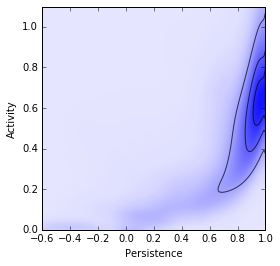

In [174]:
# plot average parameter distribution
to_plot = np.mean(timeAveragedPosteriors, axis=0)

plt.figure(figsize=(4, 4))
plt.contour(to_plot.T, [densityRegion(to_plot, alpha) for alpha in [0.10, 0.25, 0.50]],
                extent=[-1, 1, 0, 1.5], linewidths=1, colors='k', alpha=0.7)

plt.imshow((to_plot.T)**1, origin=0, extent=[-1, 1, 0, 1.5], aspect='auto', 
           cmap=sns.light_palette('blue', as_cmap=True))#sns.light_palette('red', as_cmap=True))

plt.xlabel('Persistence')
plt.ylabel('Activity')  # TODO: Units?
plt.xlim(-0.6, 1)
plt.ylim(0, 1.1)

#plt.savefig('plots/density_plastic.png')

In [82]:
densities_per_category[category] = np.mean(timeAveragedPosteriors, axis=0)

In [85]:
densities_per_category

{'alive': array([[  2.59519119e-22,   5.64444169e-11,   6.10261328e-08, ...,
           1.60763650e-06,   1.60633102e-06,   1.60424573e-06],
        [  3.65914451e-11,   1.02860655e-06,   3.05982667e-06, ...,
           1.48035764e-06,   1.47882355e-06,   1.47703081e-06],
        [  9.14538327e-13,   3.67413348e-08,   1.80508564e-07, ...,
           1.43122827e-06,   1.43003788e-06,   1.42880720e-06],
        ..., 
        [  9.23557790e-06,   5.21860759e-06,   3.98473240e-06, ...,
           7.97851023e-07,   7.99009186e-07,   8.00320896e-07],
        [  1.05797496e-05,   6.30675045e-06,   4.10058571e-06, ...,
           7.42976937e-07,   7.44394190e-07,   7.45619556e-07],
        [  1.95505754e-06,   6.72233916e-06,   5.62793915e-06, ...,
           6.89533802e-07,   6.90424781e-07,   6.90701926e-07]]),
 'fibro': array([[  2.28485267e-05,   2.17950194e-05,   2.64738671e-05, ...,
           1.93578032e-07,   1.93389445e-07,   1.92970929e-07],
        [  2.48743754e-05,   2.68664634e-0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 20
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 19
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 20
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 18
         Function evaluations: 40
Optimization terminated successful

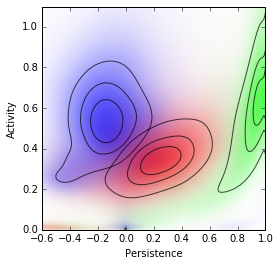

In [175]:
plt.figure(figsize=(4, 4))
rgb_arr = np.ones((200, 200, 3))

max_intensity = 0.7

rgb_arr[..., 0] -= max_intensity * densities_per_category['alive'].T / np.max(densities_per_category['alive'])
rgb_arr[..., 1] -= max_intensity * densities_per_category['alive'].T / np.max(densities_per_category['alive'])

rgb_arr[..., 1] -= max_intensity * densities_per_category['plastic'].T / np.max(densities_per_category['plastic'])
rgb_arr[..., 2] -= max_intensity * densities_per_category['plastic'].T / np.max(densities_per_category['plastic'])

rgb_arr[..., 0] -= max_intensity * densities_per_category['fibro'].T / np.max(densities_per_category['fibro'])
rgb_arr[..., 2] -= max_intensity * densities_per_category['fibro'].T / np.max(densities_per_category['fibro'])

rgb_arr = rgb_arr.clip(min=0)

plt.imshow(rgb_arr, origin=0, extent=[-1, 1, 0, 1.5], aspect='auto', interpolation='none')
    
for density in densities_per_category.values():
    plt.contour(density.T, [densityRegion(density, alpha) for alpha in [0.10, 0.25, 0.50]],
                    extent=[-1, 1, 0, 1.5], linewidths=1, colors='k', alpha=0.7)

plt.xlabel('Persistence')
plt.ylabel('Activity')  # TODO: Units?

plt.xlim(-0.6, 1)
plt.ylim(0, 1.1)

plt.savefig('plots/density_all.png', dpi=300)

In [ ]:
# Mean parameter values over time
plt.plot(S.posteriorMeanValues[0], label='Mean Persistence')  # first parameter (persistence)
plt.plot(S.posteriorMeanValues[1], label='Mean Activity')  # second parameter (cell speed)
plt.legend()

In [ ]:
# compute mean persistence of cell from parameter distribution and grid
print 'Mean persistence = {}'.format(np.sum(averagePosterior*S.grid[0]))